In [1]:
from calcimetry.mongo_api import MongoInfo
from calcimetry.thumbnail_api import ThumbnailAPI
from PIL import Image
import matplotlib.pyplot as plt
import io
import random
import base64

HOST = 'localhost'
PORT = 27010

# Load Dataset

def get_histo(img):
    gray = img.convert('L')

    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.set_axis_off()
    ax.plot(gray.histogram())
    img_byte_array = io.BytesIO()
    fig.savefig(img_byte_array, format='jpeg')
    plt.close(fig)
    return base64.b64encode(img_byte_array.getvalue()).decode()


random.seed(1)

mongo_info = MongoInfo(host=HOST, port=PORT)
thumb_list = []
with ThumbnailAPI(mongo_info=mongo_info) as thumb_api:
    size = thumb_api.size()
    print(size)
    for i in range(50):
        idx = int(random.random()*size)
        thumb = thumb_api.read(idx)
        thumb_list.append(thumb)
    #plt.imshow(thumb)
    

4067


In [2]:
img = thumb_list[0].jpg
print(thumb_list[0].measurement)
# img.show()

Measure: #547 (image 479): (120->27) quality:10



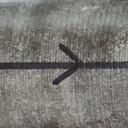
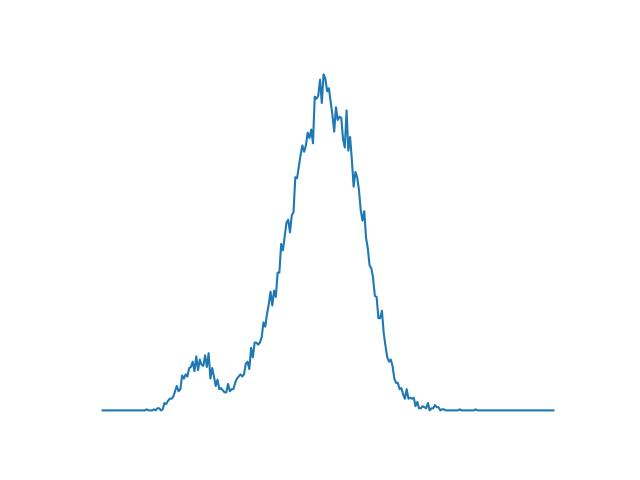
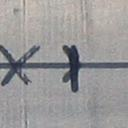
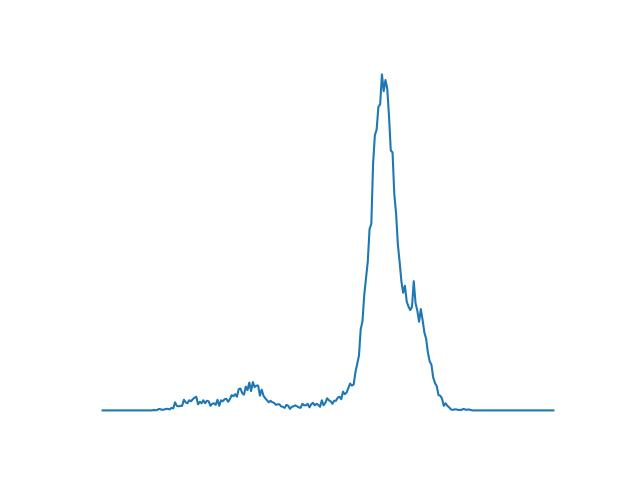
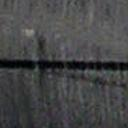
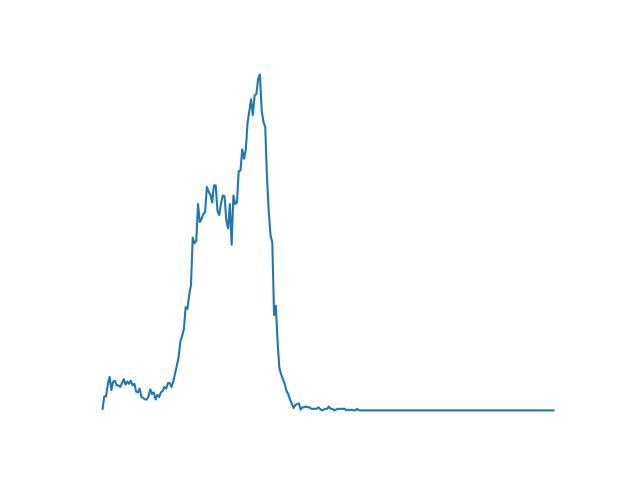
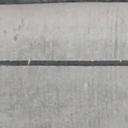
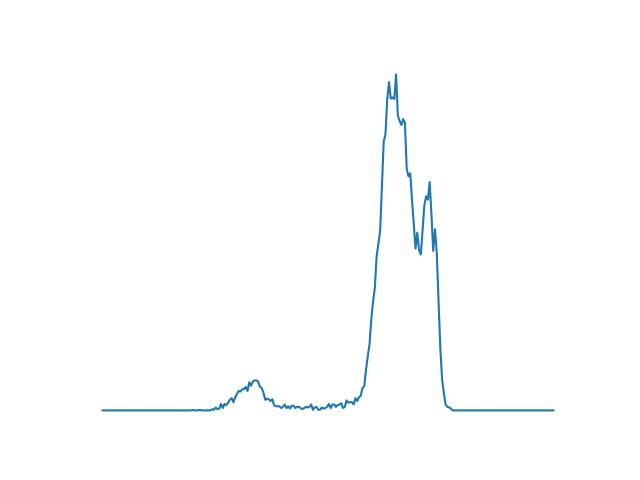
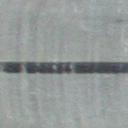
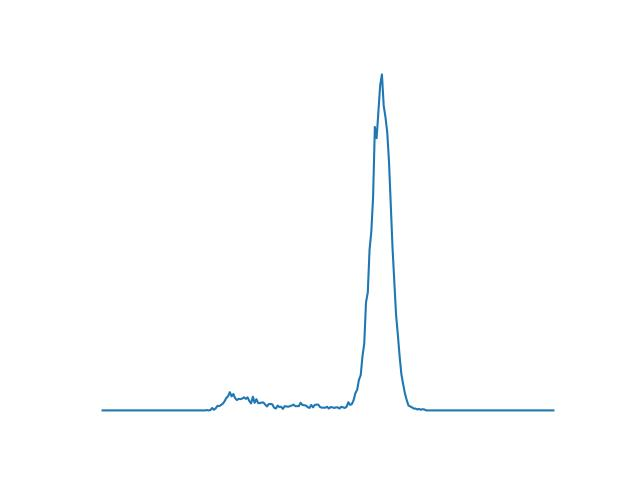
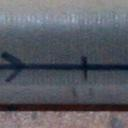
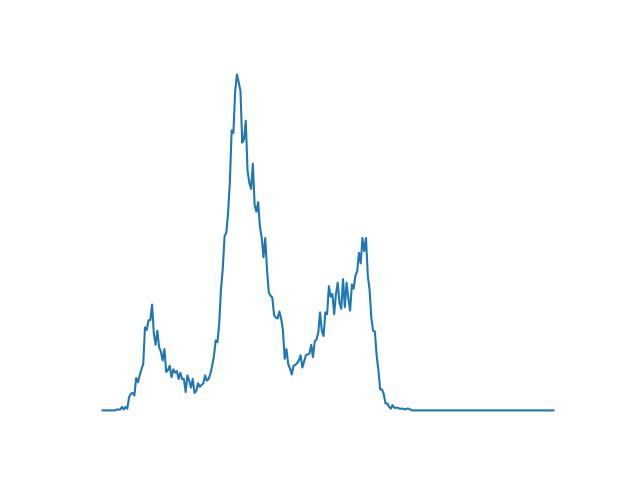
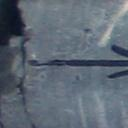
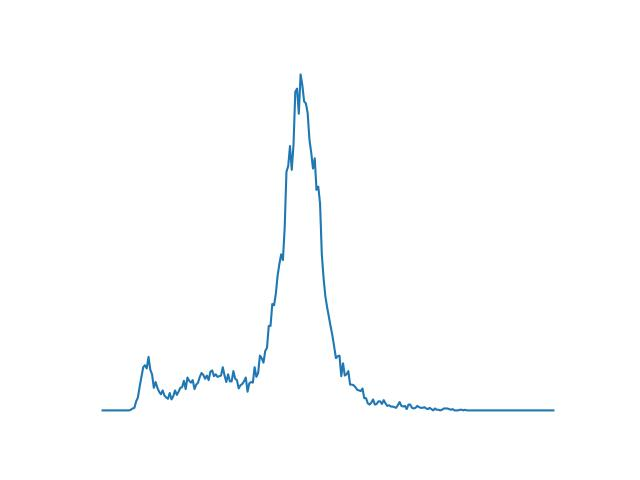
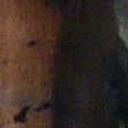
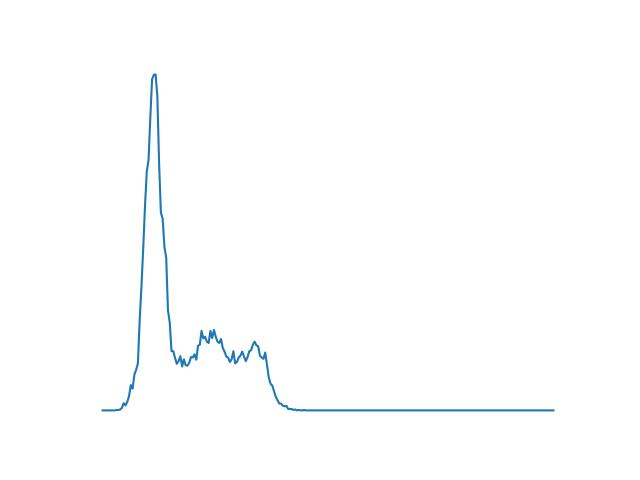
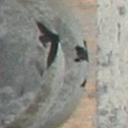
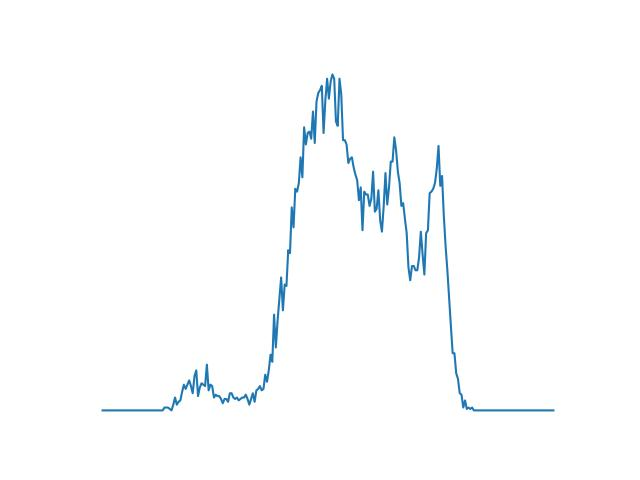
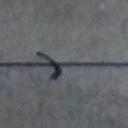
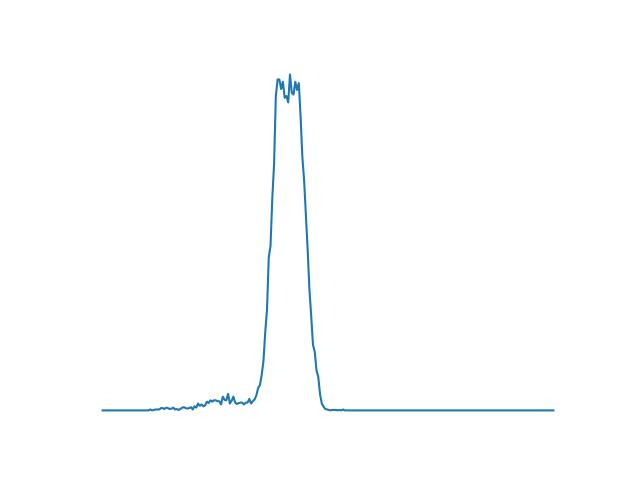
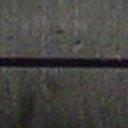
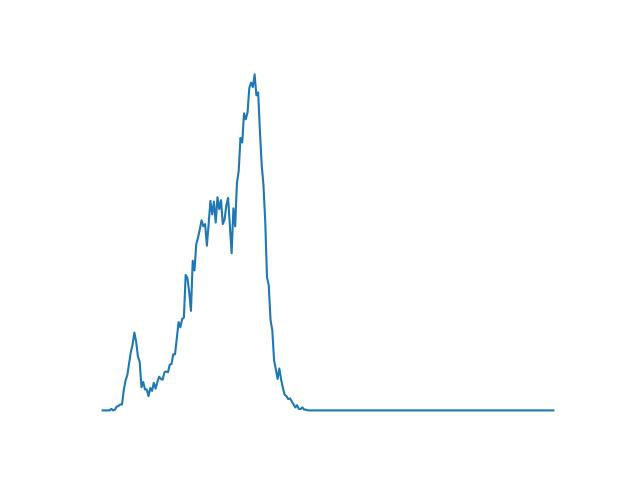
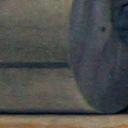
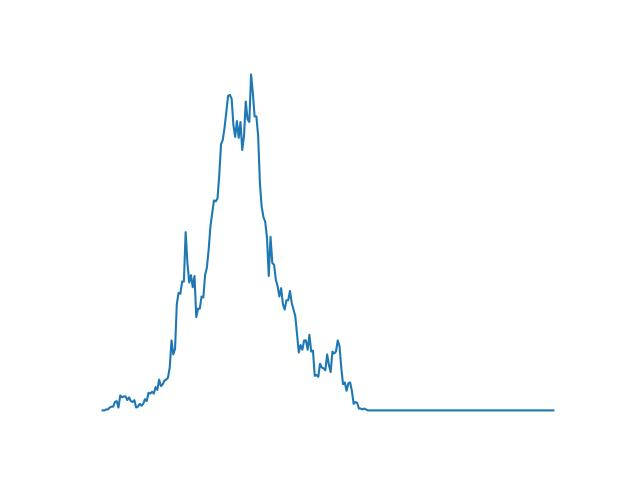
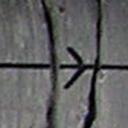
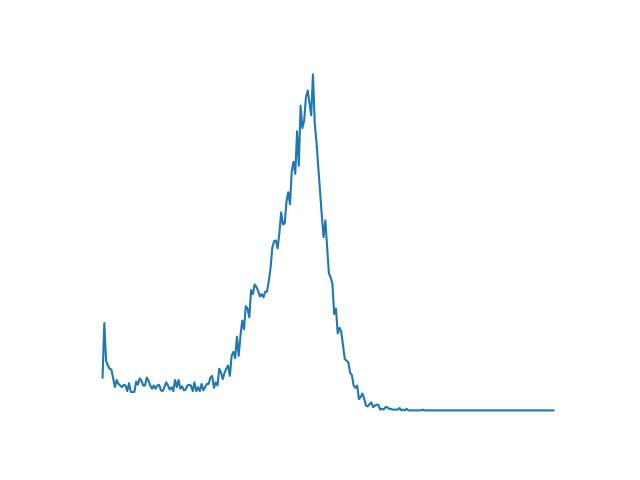
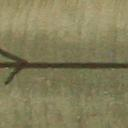
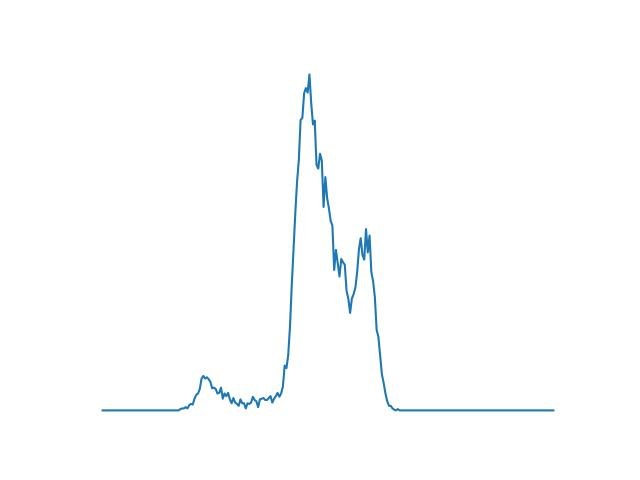
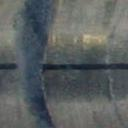
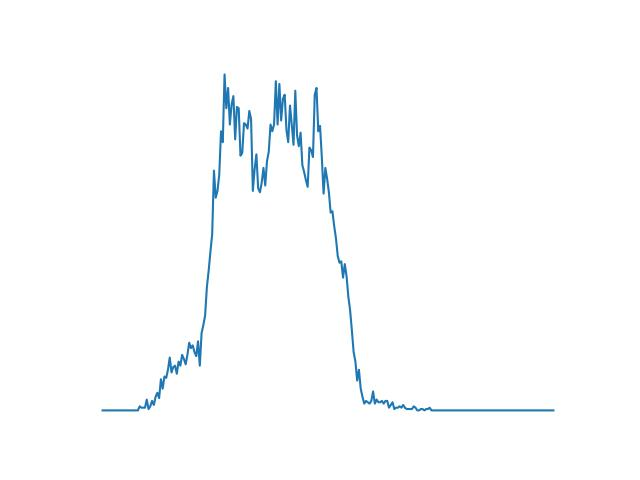
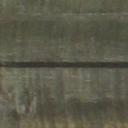
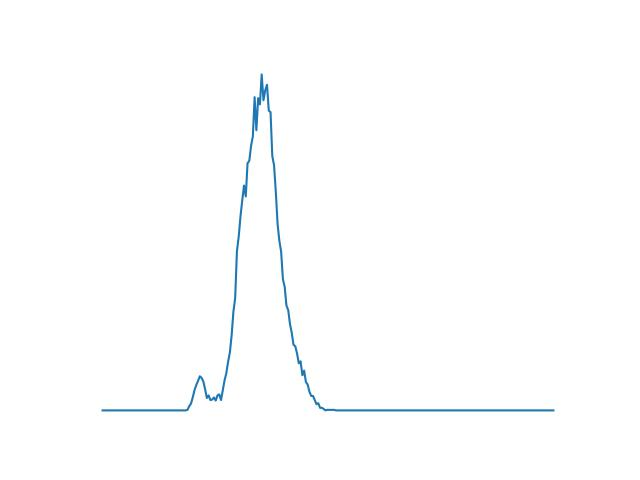
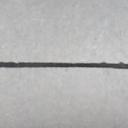
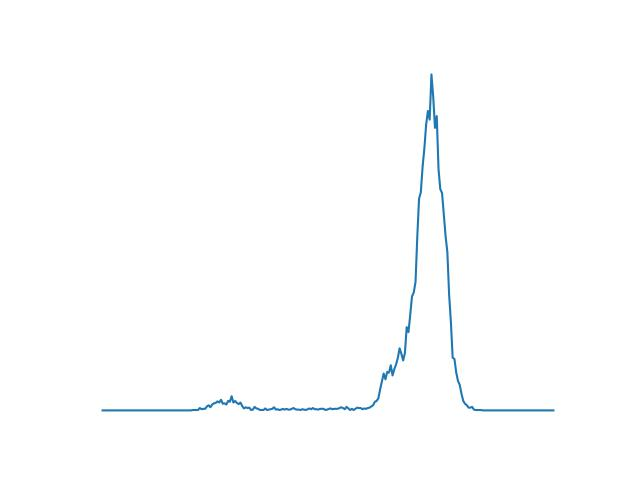
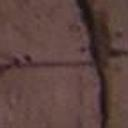
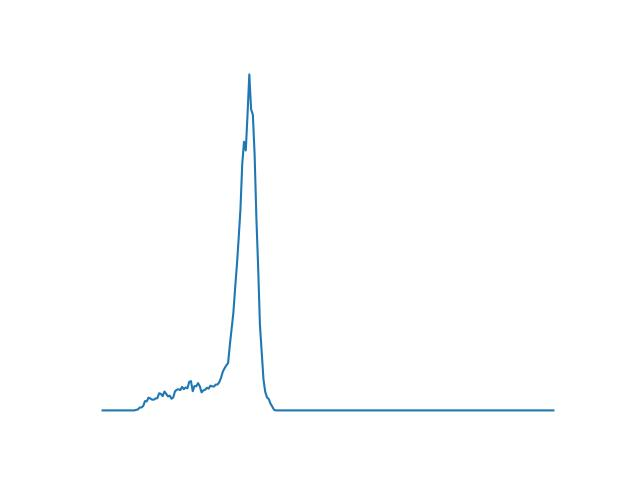
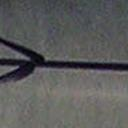
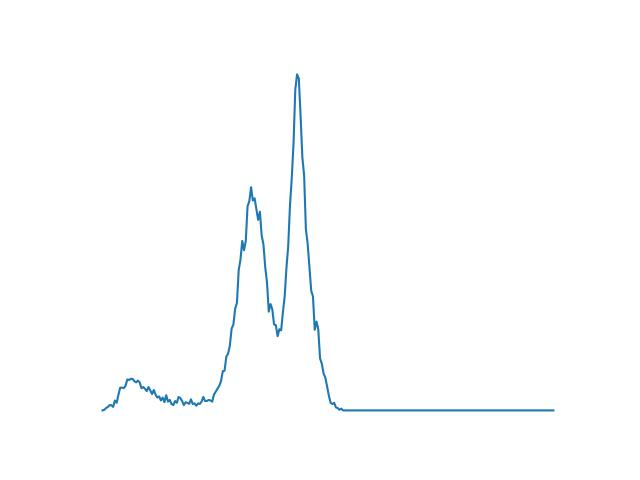
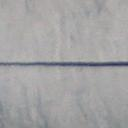
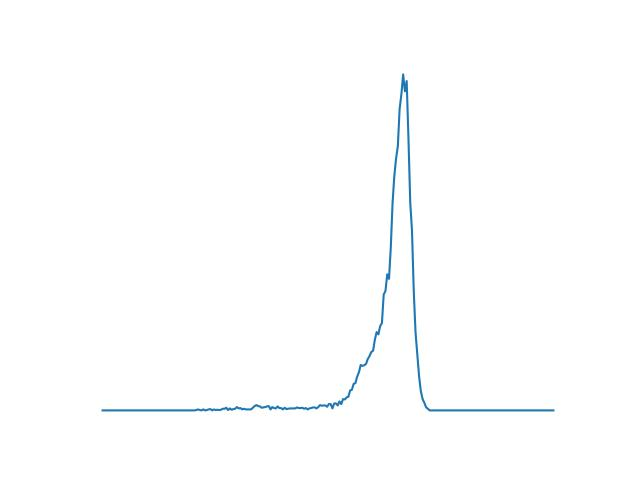
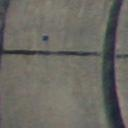
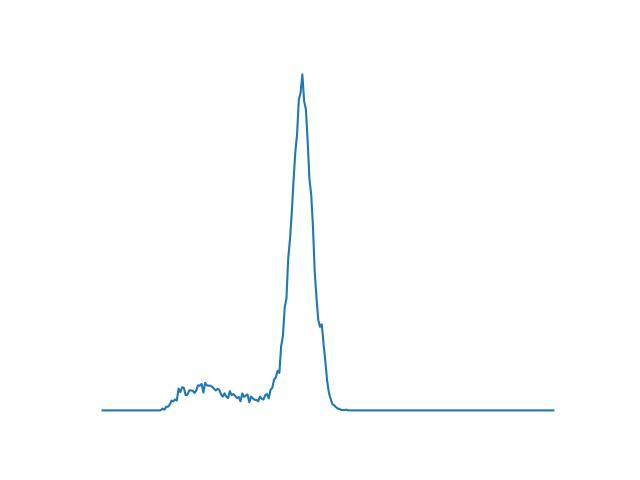
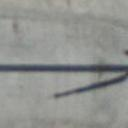
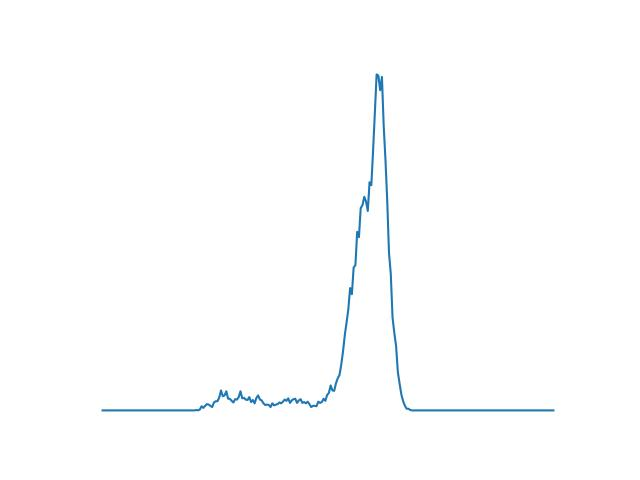
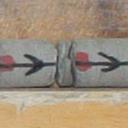
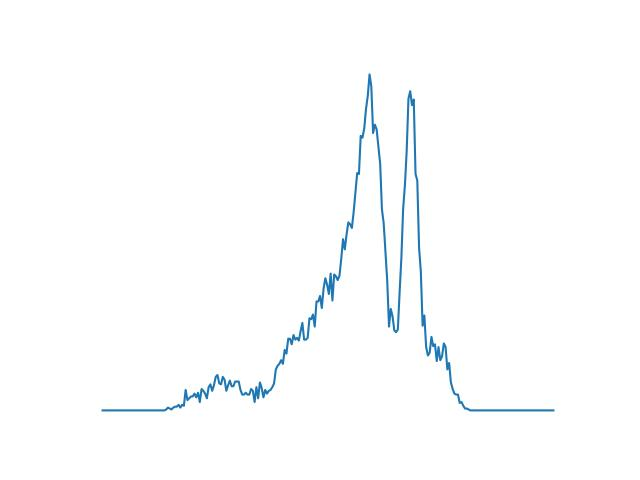
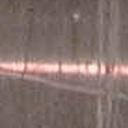
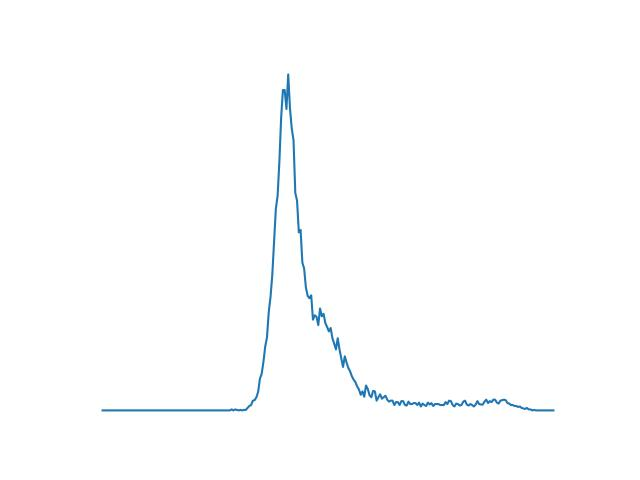
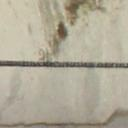
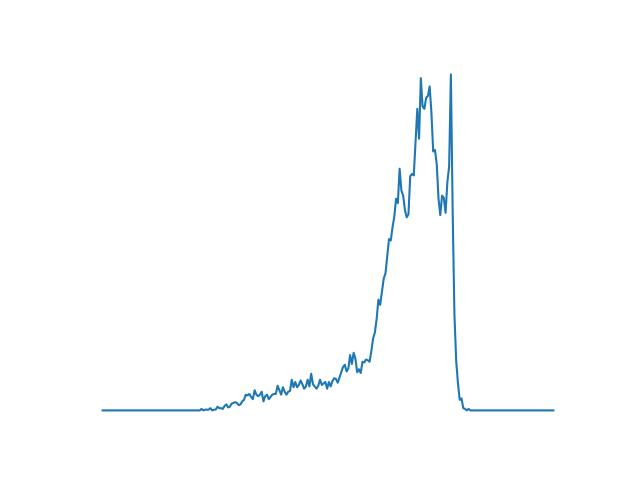
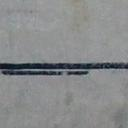
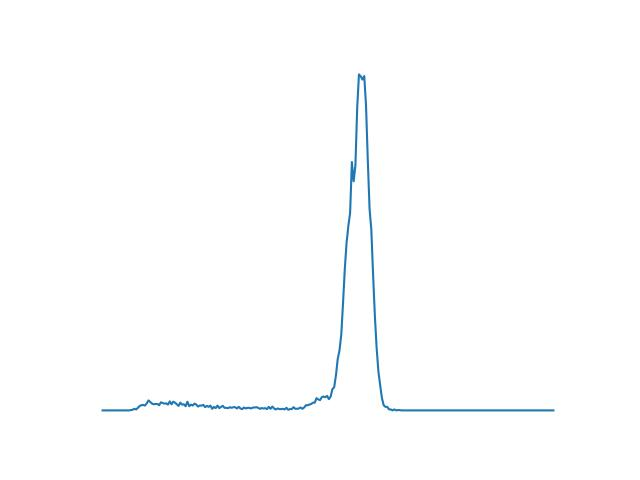
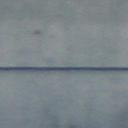
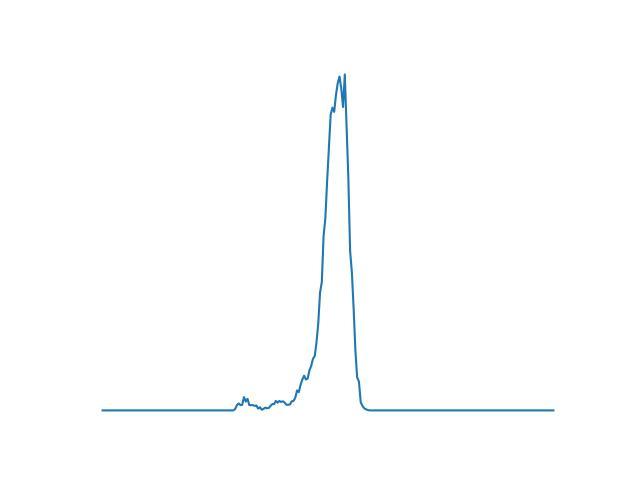
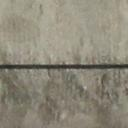
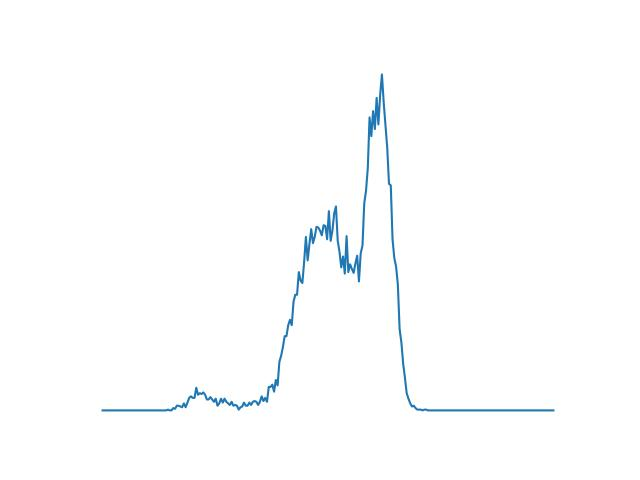
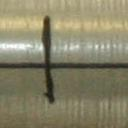
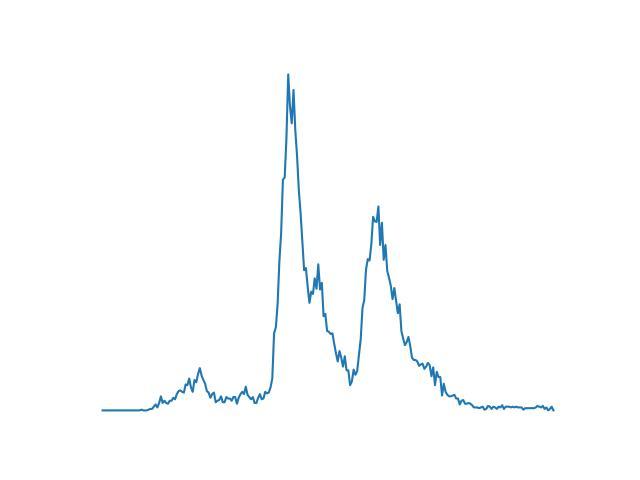
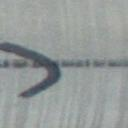
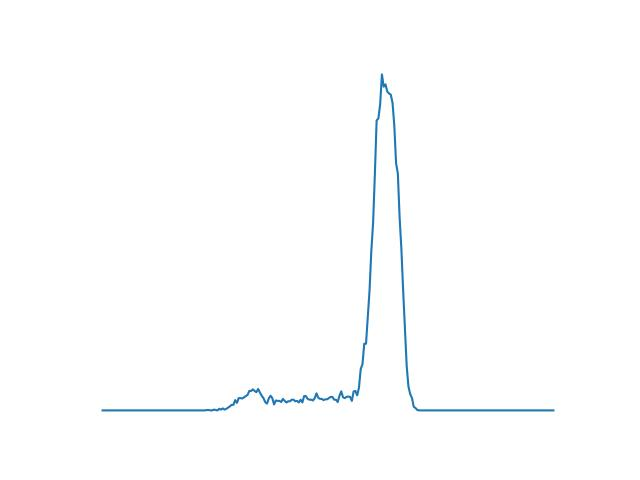
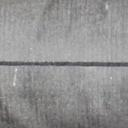
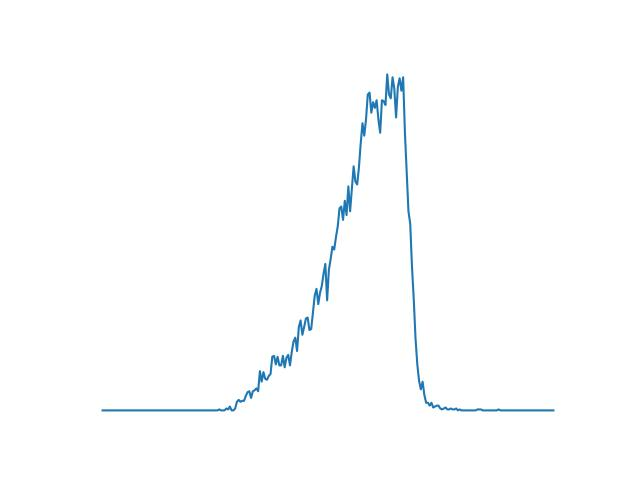
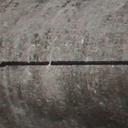
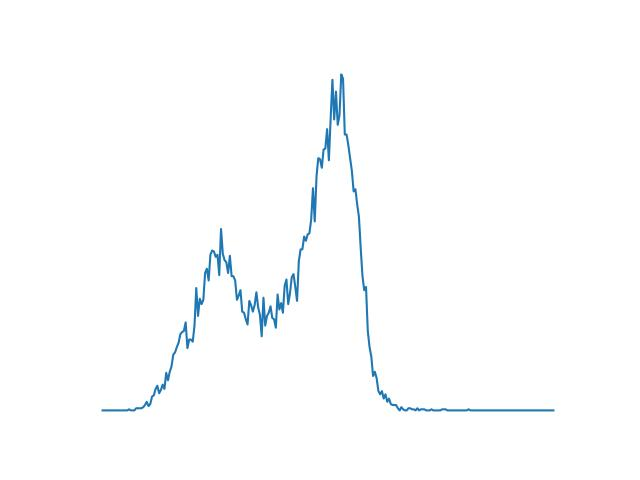
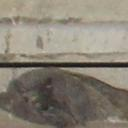
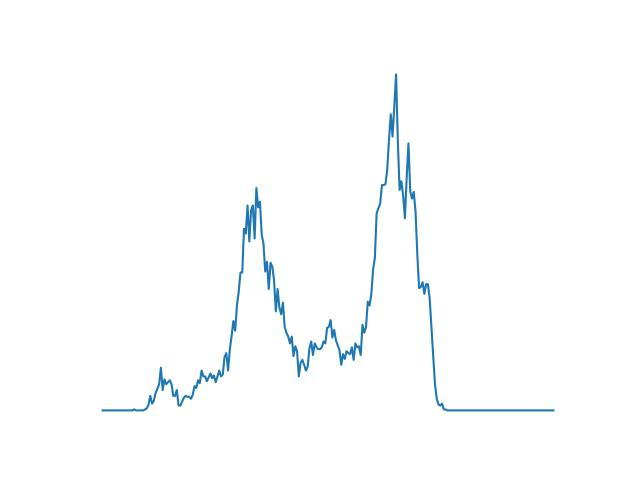
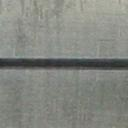
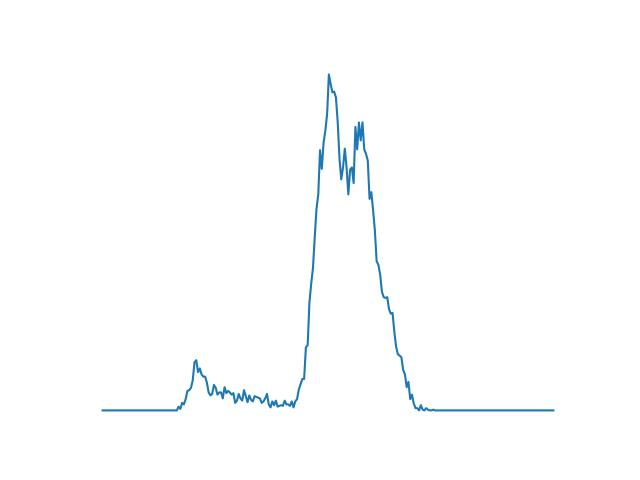
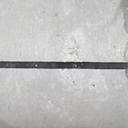
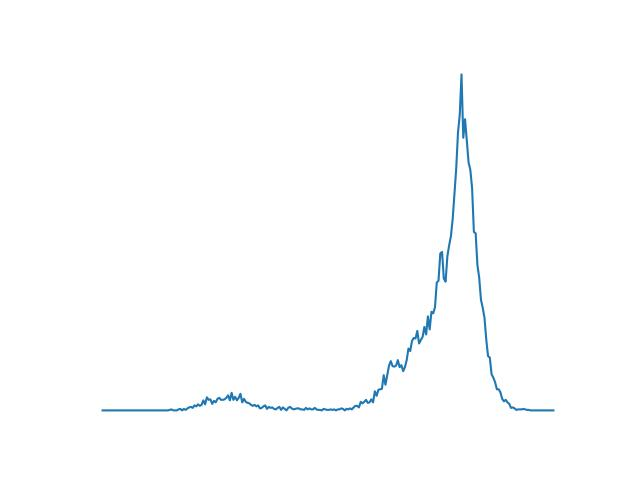
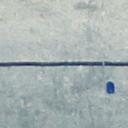
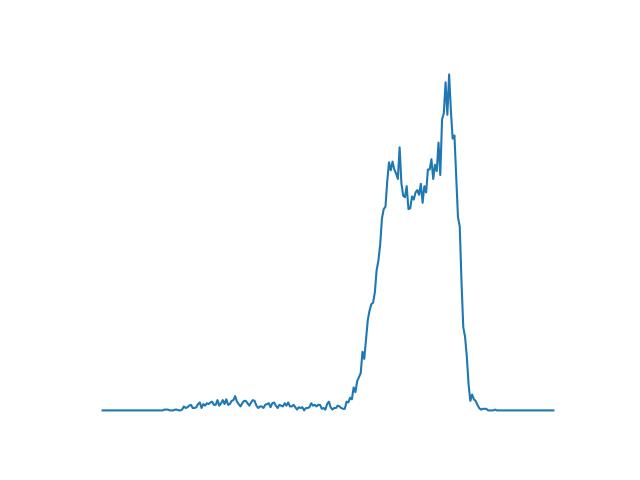
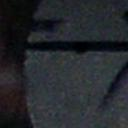
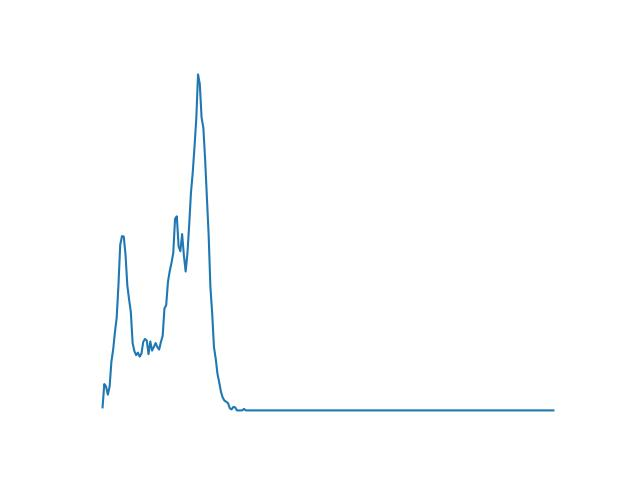
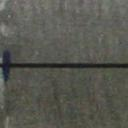
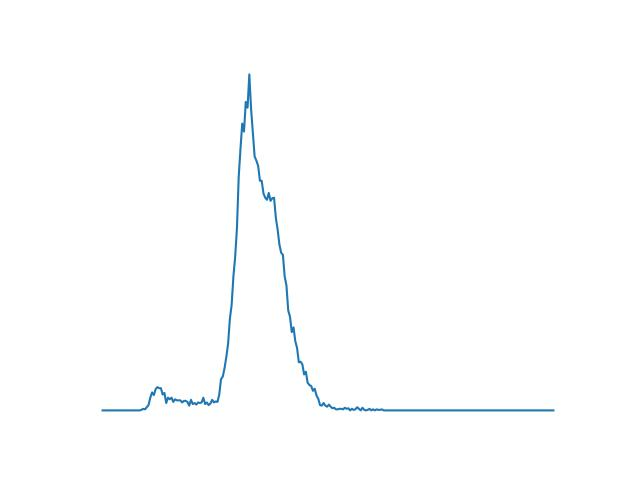
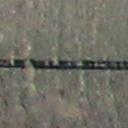
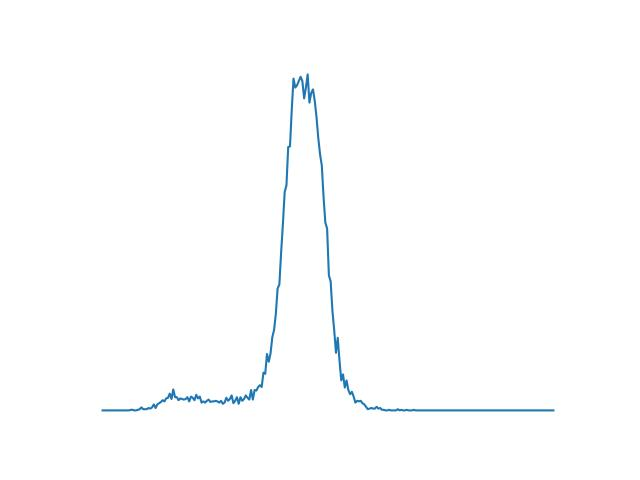
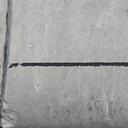
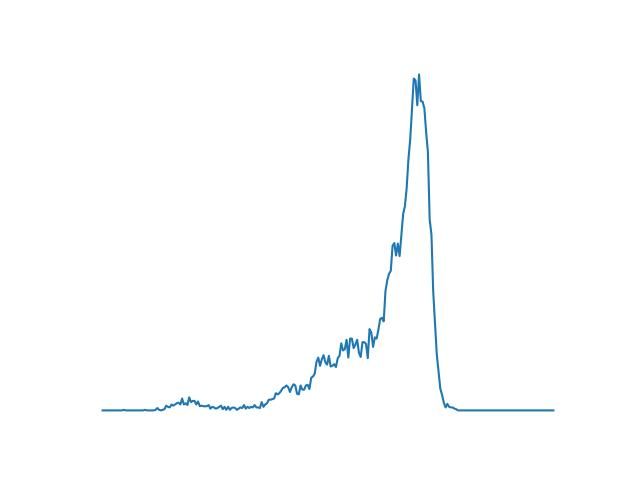
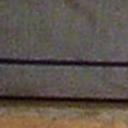
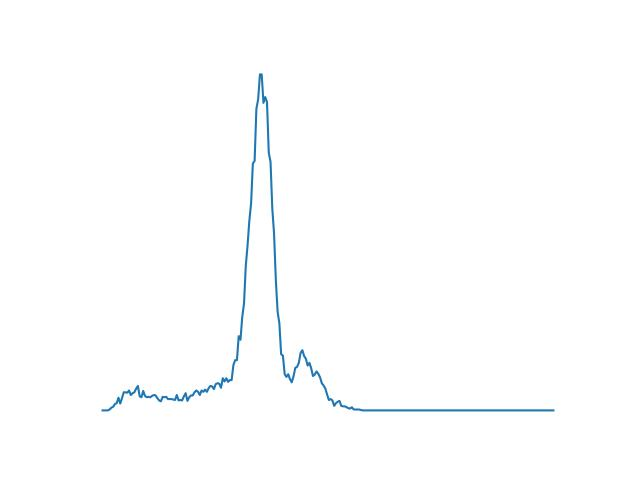
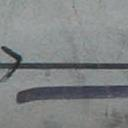
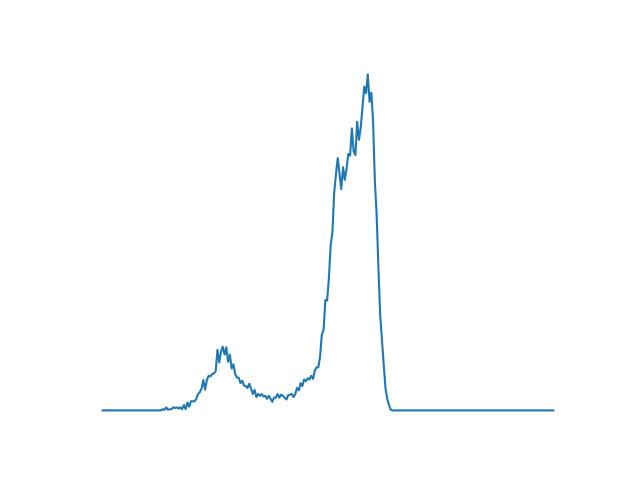
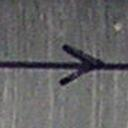
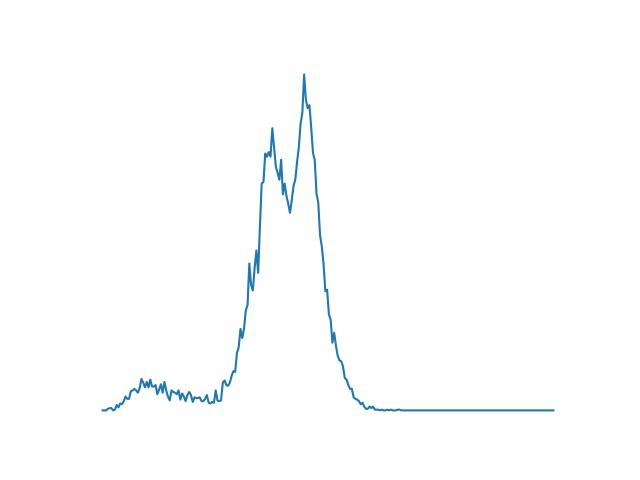
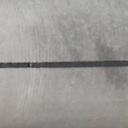
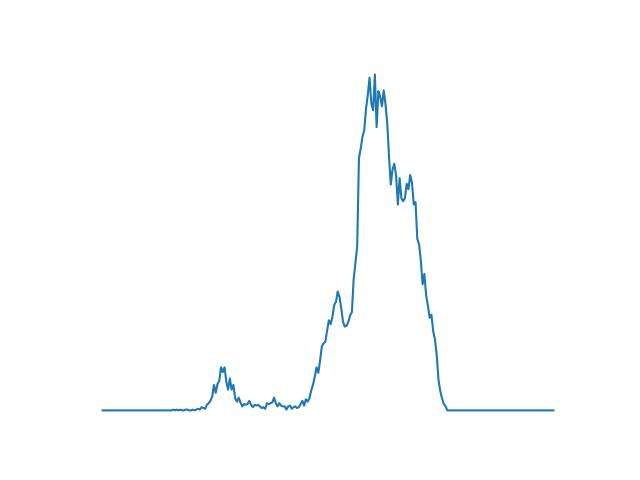
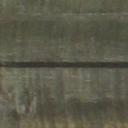
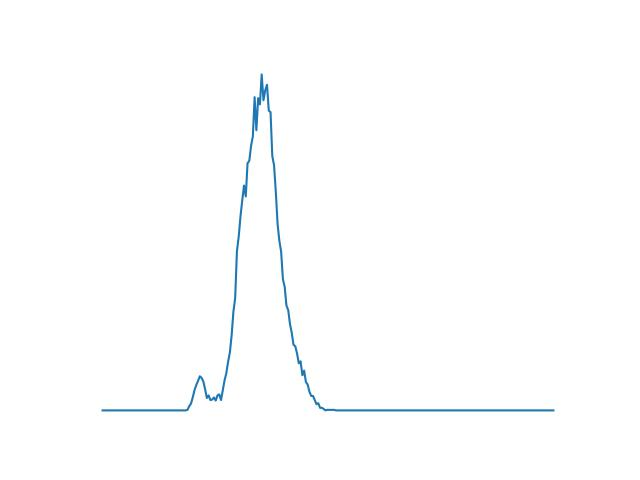
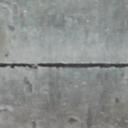
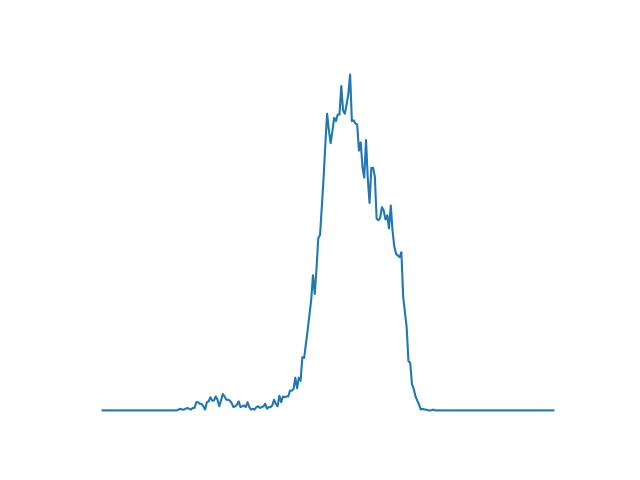
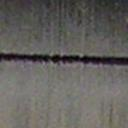
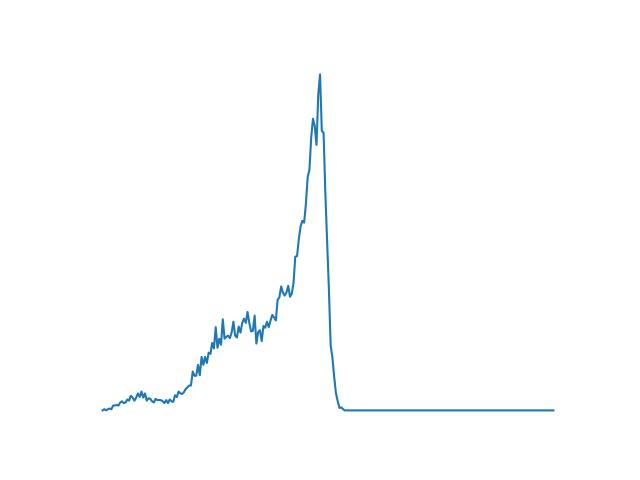
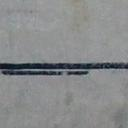
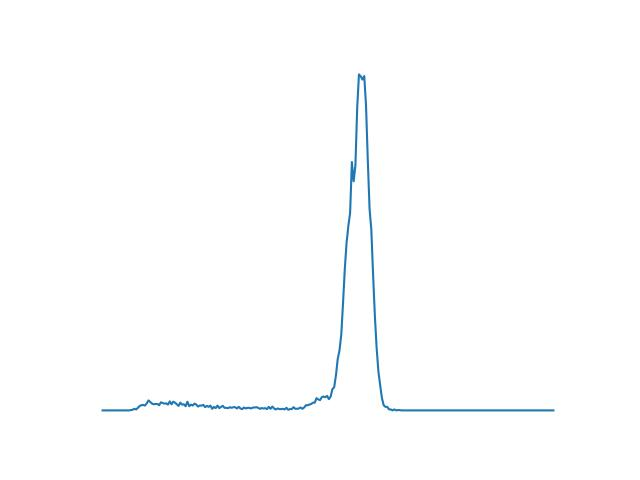
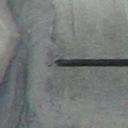
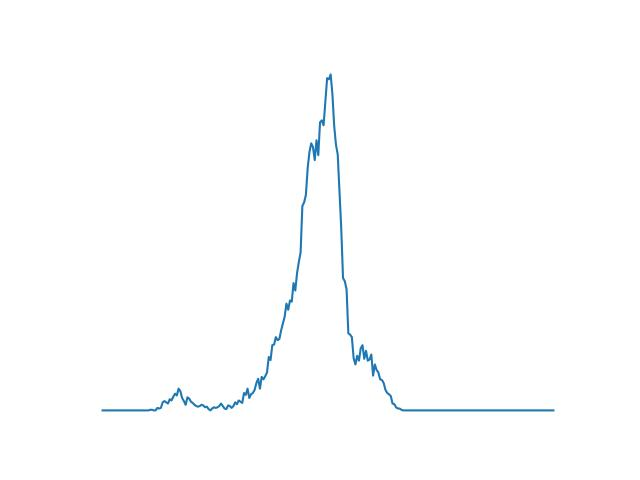
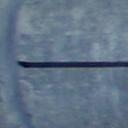
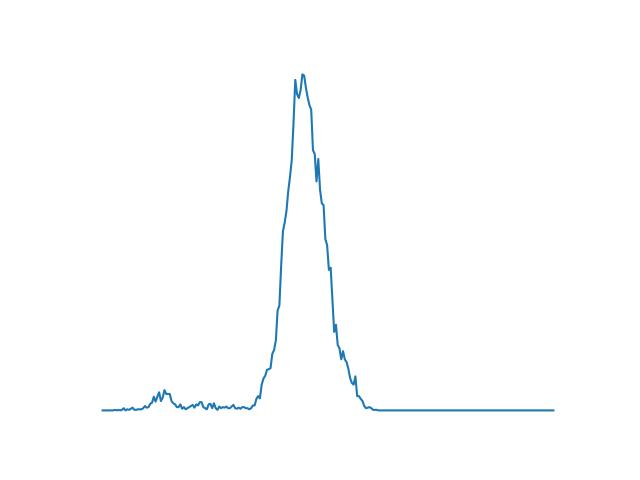

In [3]:
from IPython.display import Image, HTML, display

def to_base64(img: Image):
    byte_array = io.BytesIO()
    img.save(byte_array, format='jpeg')
    return base64.b64encode(byte_array.getvalue()).decode()

html_str = "<div style='display: inline-block; align:justify; border: 1px solid white;'>"
html_str +="<img style='width: 128px; margin: 0px; float: left; ' src='data:image/jpg;base64,%s' />"
html_str +="<img style='width: 128px; margin: 0px; float: left; 'src='data:image/jpg;base64,%s' />"
html_str +="<P style='text-align: center;'>%s (%s)</P>"
html_str +="</div>"

imagesList=''.join( [ html_str % (
    to_base64(t.jpg), 
    get_histo(t.jpg), 
    t.measurement.val_1m, 
    t.measurement.image_id) for t in thumb_list ]
    )
display(HTML(imagesList))



### Création d'un DataFrame pandas

In [4]:
import pandas as pd
import numpy as np
from calcimetry.thumbnail_api import ThumbnailAPI

n_bins = 6
def get_histo(t, n_bins):
    w, h = t.jpg.size
    histo, bins = np.histogram(t.jpg, bins=n_bins)
    return histo.astype(np.float64) / (w*h)

#create dataframe for learing
columns = [
    "focus", "mean_grad", "mean_color", "brisque"
]
for i in range(n_bins):
    columns.append(f"bin_{i}")
columns.append('target')
    
data = []

with ThumbnailAPI(mongo_info=mongo_info) as thumb_api:
    size = thumb_api.size()    
    for idx in range(size):
        idx = int(random.random()*size)
        t = thumb_api.read(idx)
        row = [t.quality.focus, t.quality.gradient['ave'], np.mean(t.quality.colours), t.quality.brisque]
        histo = get_histo(t, n_bins)
        for i in range(n_bins):
            row.append(histo[i])
        row.append(float(t.measurement.val_1m))
        data.append(row)
    
df = pd.DataFrame(data, columns=columns)
df.head()

,focus,mean_grad,mean_color,brisque,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,target
0,416.905777,43.610737,152.548202,12.466003,0.036682,0.081604,0.018860,0.221619,1.836975,0.804260,25.0
1,146.302903,41.768726,101.535194,20.583191,0.147644,0.182007,1.119751,1.003906,0.524292,0.022400,25.0
2,66.924931,32.643732,115.806037,29.405945,0.018982,0.181885,0.835083,0.910156,0.820312,0.233582,25.0
3,132.465762,38.082289,109.756371,24.846863,0.049744,0.378174,0.302124,1.550598,0.690186,0.029175,19.0
4,187.562354,46.739868,131.360280,23.024597,0.058960,0.282898,0.121643,0.996582,1.439880,0.100037,28.0


Normalisons les variables d'entrées $z_i=(x_i-\mu_i)/\sigma_i$

In [5]:
for c in columns:
    if c == 'target':
        continue
    mean = df[c].mean()
    std = df[c].std()
    df[c] = (df[c] - mean) / std 

df.head()

,focus,mean_grad,mean_color,brisque,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,target
0,1.256436,0.540013,1.662182,-1.315887,-0.372502,-0.499353,-1.015126,-1.348632,1.231962,1.330270,25.0
1,-0.147918,0.383884,-0.112491,-0.658227,0.692938,-0.106824,1.460048,0.208747,-0.840658,-0.688539,25.0
2,-0.559867,-0.389550,0.383972,0.056600,-0.542456,-0.107301,0.820019,0.022109,-0.373266,-0.143256,25.0
3,-0.219729,0.071422,0.173512,-0.312781,-0.247087,0.660100,-0.378253,1.297102,-0.578726,-0.671046,19.0
4,0.066207,0.805238,0.925083,-0.460422,-0.158593,0.287615,-0.784035,0.194166,0.604982,-0.488076,28.0


Regardons un peu les corrélations entre les variables d'entrées

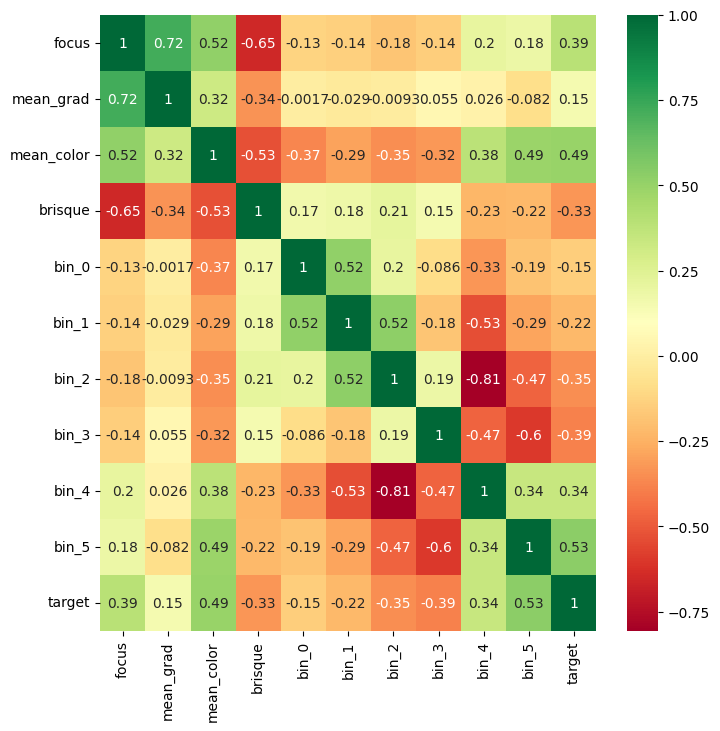

In [6]:
import seaborn as sns #visualization package
corr = df.corr()
plt.subplots(figsize=(8,8))
sns.heatmap(corr,cmap= 'RdYlGn',annot=True)
plt.show()

- Positif: Aucune des variables $x_i$ d'entrées ne sont corrélées entre elles vraiment.
- Négatif: On voit aussi que la cible (target) n'est pas vraiment corrélées avec aucune des variables d'entrées

## Modélisation

1) On scinde en (features, target)

In [7]:
# #independent variables / explanatory variables
# # x = df.drop(labels='target', axis=1)  #axis=1 means we drop data by column.
# x = df[['mean_color', 'focus', 'bin_5']]

# #dependent variable / response / target variable.
# y = df['target']

In [8]:
# y.astype(np.int32)

2) On scinde en dataset d'apprentissage et de validation

In [9]:
from lazypredict.Supervised import LazyRegressor
from sklearn.utils import shuffle
import numpy as np

#independent variables / explanatory variables
x = df.drop(labels='target', axis=1)  #axis=1 means we drop data by column.
y = df['target']

X, y = shuffle(x,y, random_state=123)
X = X.astype(np.float32)

offset = int(X.shape[0] * 0.9)


X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

3) On réalise la régression

3.1 LazyPredict

In [10]:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)

models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

  5%|▍         | 2/42 [00:00<00:12,  3.17it/s]

ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (5,6) we computed 1552.5428466796875 but the user-supplied value was 1552.5426025390625.


 57%|█████▋    | 24/42 [00:05<00:02,  6.79it/s]

LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (5,6) we computed 1552.5428466796875 but the user-supplied value was 1552.5426025390625.


100%|██████████| 42/42 [20:50<00:00, 29.77s/it]


                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
ExtraTreesRegressor                          0.80       0.81  8.12        0.86
RandomForestRegressor                        0.78       0.78  8.65        2.28
XGBRegressor                                 0.76       0.77  8.92        3.28
BaggingRegressor                             0.75       0.75  9.20        0.26
LGBMRegressor                                0.73       0.73  9.60        0.18
HistGradientBoostingRegressor                0.72       0.73  9.73        0.85
DecisionTreeRegressor                        0.60       0.61 11.56        0.05
GradientBoostingRegressor                    0.58       0.59 11.84        0.84
ExtraTreeRegressor                           0.54       0.55 12.41        0.01
MLPRegressor                                 0.48       0.49 13.22        3.47
KNeighborsRegressor                          0.48   

In [11]:
from sklearn.ensemble import ExtraTreesRegressor                          
from sklearn.metrics import mean_squared_error

reg = ExtraTreesRegressor(n_estimators=100, random_state=123).fit(X_train, y_train)
reg.score(X_test, y_test)

0.8088864564405764

In [12]:
y_pred = reg.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

8.119898965735917

In [13]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.8088864564405764

In [14]:
adjusted_r2_score = 1 - (1-r2_score(y_test, y_pred)) * (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
adjusted_r2_score

0.8040603568557425

4) On évalue le modèle

In [15]:
from sklearn import metrics as mt
predicted_y = y_pred
test_y = y_test
print("1) The model explains,", np.round(mt.explained_variance_score(test_y,predicted_y)*100,2),"% variance of the target w.r.t features is")
print("2) The Mean Absolute Error of model is:", np.round(mt.mean_absolute_error(test_y,predicted_y ),2))
print("3) The R-Square score of the model is " , np.round(mt.r2_score(test_y,predicted_y),2))

1) The model explains, 81.0 % variance of the target w.r.t features is
2) The Mean Absolute Error of model is: 3.59
3) The R-Square score of the model is  0.81


Text(0.5, 1.0, 'Train Plot')

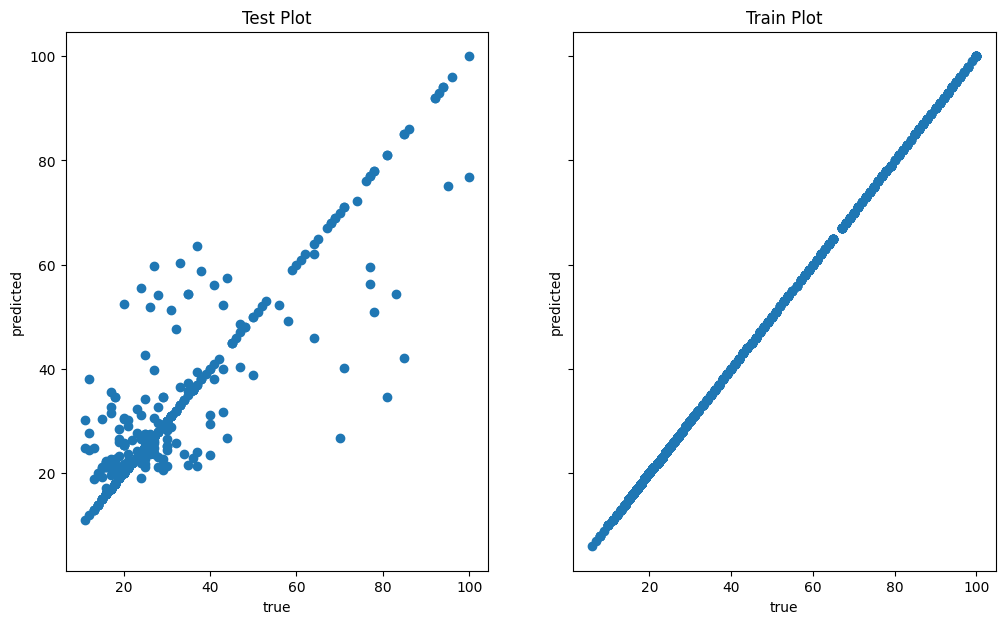

In [16]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,7),
                             sharey=True)

ax1.scatter(test_y, predicted_y)
ax1.set_xlabel('true')
ax1.set_ylabel('predicted')
ax1.set_title('Test Plot')

x_pred = reg.predict(X_train)
ax2.scatter(y_train, x_pred)
# scatter(test_y, predicted_y)
ax2.set_xlabel('true')
ax2.set_ylabel('predicted')
ax2.set_title('Train Plot')


Match DataFrame Creation

MAX VALUE = 46.28


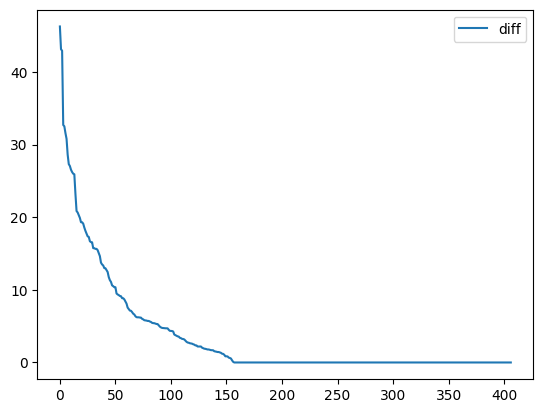

In [17]:
diff = pd.DataFrame(columns=['diff'])
predicted_y_column = pd.Series(predicted_y).reset_index()
predicted_y_column = predicted_y_column.rename(columns={predicted_y_column.columns[1]: 'target'}).drop(columns=["index"], axis = 1)
test_y_column = test_y.reset_index().drop(columns=["index"], axis = 1)
diff['diff'] = abs(test_y_column['target'] - predicted_y_column['target'])#.sort_values().sort_index()
diff.sort_values(by = 'diff', ascending=False).reset_index().drop(columns=["index"], axis = 1).plot()
print(f'MAX VALUE = {max(diff["diff"])}')

Let's take a confidence_threshold equale to 7 and extract all the mongoDB best matchs references.

In [18]:
confidence_threshold = 7
rslt_df = test_y[abs(test_y - predicted_y) < confidence_threshold]
match_indexes = list(rslt_df.index)
match_thumb_list = []

with ThumbnailAPI(mongo_info=mongo_info) as thumb_api:
    for idx in match_indexes : 
        t = thumb_api.read(idx)
        match_thumb_list.append(t)
    
mongo_match_rslt_df = pd.DataFrame(match_thumb_list, columns=None)
print(f'number of best matchs == > {len(mongo_match_rslt_df)}')
mongo_match_rslt_df.head()

number of best matchs == > 342


,0
0,<calcimetry.thumbnail.Thumbnail object at 0x00...
1,<calcimetry.thumbnail.Thumbnail object at 0x00...
2,<calcimetry.thumbnail.Thumbnail object at 0x00...
3,<calcimetry.thumbnail.Thumbnail object at 0x00...
4,<calcimetry.thumbnail.Thumbnail object at 0x00...


Cross-validated scores: [0.73580134 0.73254939 0.69828733 0.77208911]
Cross-Predicted Accuracy: 0.7351756212074614


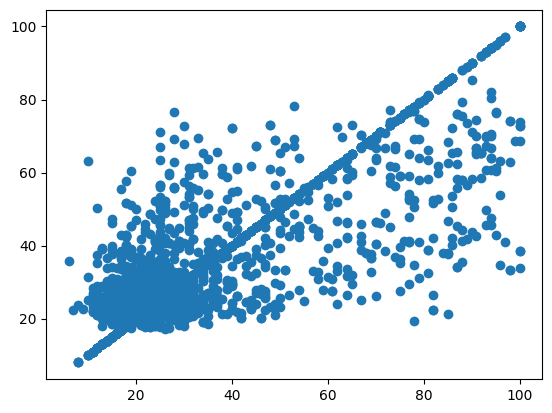

In [22]:
from sklearn.model_selection import cross_val_score, cross_val_predict
# Perform 6-fold cross validation
scores = cross_val_score(ExtraTreesRegressor(), X, y, cv=4)
print("Cross-validated scores:", scores)

# Make cross validated predictions
predictions = cross_val_predict(ExtraTreesRegressor(), X, y, cv=4)
plt.scatter(y, predictions)
accuracy = r2_score(y, predictions)

print("Cross-Predicted Accuracy:", accuracy)